# TP3: Essential Matrix

## Instructions
Read, understand, and complete the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf. 

Before sending your notebook, please make sure your code can be run by restarting your jupyter kernel and relaunching all the cells.

Return your work by e-mail at `gabriel.fiastre@inria.fr` using a single file (ipynb or zip) with the format `LASTNAME_FirstName_TP2.ipynb`


#### This assignment is about Two-view (Stereo) Geometry : you will compute the **Essential Matrix** F associated with N correspondences from the "house" data. You will estimate the matrix, compute the epipolar lines and implement Hartley's normalization to improve results.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

**0)** Define your path to the folder containing the data points:

In [2]:
path = 'HouseData'

You can directly use the following functions, especially `read_data` to load points in two chosen views, and `plot_edges` to visualize points from one view and the edges connecting them.

In [3]:
def file_to_array(file_path):
    """
    Params:
    -------
    file_path: str
        path to file with image points.
    
    Returns:
    --------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    """
    with open(file_path) as f:
        views = dict()
        pt2d = f.readlines()
        for line in pt2d:
            if len(line.split(" ")) == 3:
                pt_id = line.split(" ")[0]
                views[pt_id] = (float(line.split(" ")[1]), float(line.split(" ")[2][:-1]))
    pts = np.zeros((len(views), 2))
    for i in range(len(pts)):
        pts[i] = views[str(i+1)] 

    return pts


def read_data(data_path, idx1, idx2):
    """
    Params:
    -------
    data_path: str
        path to folder where 'pt_2D{}' are stored.
    idx1: int
        idx of first view.
    idx2: int 
        idx of second view.
    
    
    Returns:
    --------
    pts1, pts2, edges_processed
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx2.
    edges_processed: list
        list of tuples. (i, j) is in edges_processed if there is an edge between 
        point of idx i and point of idx j.
    """
    pt1_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx1))
    pt2_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx2))
    
    pts1 = file_to_array(file_path=pt1_2D_path)
    pts2 = file_to_array(file_path=pt2_2D_path)
    
    # Load edges
    edges_path = os.path.join(path, 'edges')

    with open(edges_path) as f:
        edges_raw = f.readlines()
        
    edges_processed = []
    for edge in edges_raw:
        if len(edge.split(" ")) == 2:
            edges_processed.append((int(edge.split(" ")[0]), int(edge.split(" ")[1][:-1])))
    min_points = np.minimum(len(pts1), len(pts2))
    
    return pts1[:min_points], pts2[:min_points], edges_processed


def plot_edges(pts, edges):
    """
    Params:
    -------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    edges: list
        list of tuples. (i, j) is in edges if there is an edge between points of indices i and j.
    
    Plots edges.
    """
    
    plt.figure()
    for i, edge in enumerate(edges):
        #print(i)
        coord1 = pts[edges[i][0] - 1]
        coord2 = pts[edges[i][1] - 1]
        x = [coord1[0], coord2[0]]
        y = [coord1[1], coord2[1]]
        plt.plot(x, y, 'ro-')

For this exercise, let us use views 2 and 5 of the house:

**1)** Load the data corresponding to images 2 and 5 using `read_data`.

In [4]:
data = read_data(path, 1, 2)

**2)** Use `plot_edges` to show show the edges overlayed over images 2 and 5.

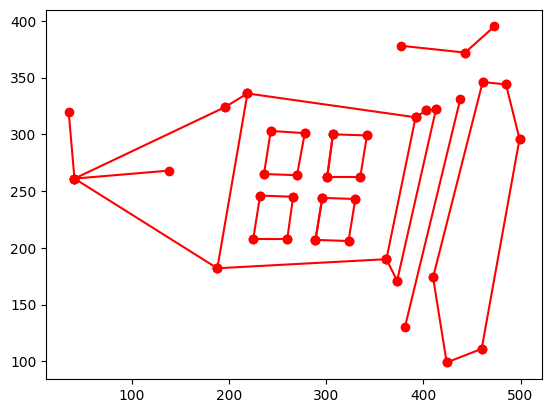

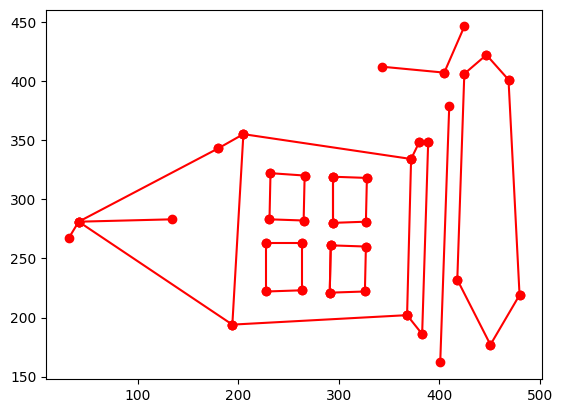

In [5]:
plot_edges(data[0], data[2])
plot_edges(data[1], data[2])

**3.a)** Compute the fundamental matrix F directly from these points using
homogeneous linear least-squares.

In [6]:
def normalize(pts, goal_std=2):
    mean = np.mean(pts, axis=0)
    std = np.std(pts, axis=0)
    return (pts - mean) * goal_std / std

In [7]:
# Compute the fundamental matrix F using homogeneous linear least-squares

"""
ces gros commentaires c'est surtout pour moi :o
"""

"""
p^T E p' = 0
E = [t_x] R
[t_x] : antisymetric matric associée à t, vecteur entre les épipôles
R : rotation entre les deux plans image

E is the essential matrix between the two views

E p' = l est l'équation de la droite épipolaire associée à p' (et E^T p = l' pour p)

avec assez de points on peut retrouver E.

p^hat^T E p^hat' = 0, p = K p^hat, M = K (R t)
-> p^T (K^-T E K^-1) p' = 0
E = K^T F F

F p' : toujours droite épipolaire mais pour p' pas exprimée en coordonnée normalisée

Comme pour e', E e' = 0, e' !=, on a E singulière
"""


def compute_F(pts1, pts2):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.

    Returns:
    --------
    F: np.array
        array of size (3, 3). Fundamental matrix.
    """

    """
    Eight point algorithm :

    On a 8 équations de la forme p^T E p' = 0

    (u v 1)^T F (u' v' 1) = 0
    -> (uu', uv', u, vu', vv', v, u', v', 1)^T F.flatten() = 0

    Si F_3_3 = 1, on a pareil sans les 1, et = -1

    Ou minimise sum(8points) (TODO : pas vu)

    Mauvaise idée : on va avoir des problèmes si l'image est grande et qu'on a des coordonnées toutes pourries très grandes et très petites
    Solution : normaliser les points, on recentre les points et on met la magnitude à 1 ou 2
    """

    #normalize points
    # oups, non, pas tout de suite :o
    #pts1 = normalize(pts1)
    #pts2 = normalize(pts2)

    A = np.zeros((len(pts1), 9))

    for i in range(len(pts1)):
        u, v = pts1[i]
        u_, v_ = pts2[i]
        A[i] = np.array([u*u_, u*v_, u, v*u_, v*v_, v, u_, v_, 1])
          

    # Compute SVD of A
    """
    Since A F is 0, A is singular, and we can take the last column of V as the solution
    """
    SVD = np.linalg.svd(A)
    U, S, Vh = SVD # Vh is the transpose of V

    # Solve for F
    F = Vh[-1].reshape(3, 3)

    # Check that F solves the equation
    return F

F = compute_F(data[0], data[1])
    

In [8]:
# We observe that F33 is equal to 1, so F preserves homogeneous coordinates
print(F[2, 2])

0.9998864806695508


**3.b)** Report the mean distance between the points (for example from view 1) and the corresponding epipolar lines.

#### Attention ####
_____
J'ai fait deux versions de find_intersect qui ne donnent pas les mêmes résultats, à pas grand chose près.
On a deux moyens de trouver une ligne orthogonale à la ligne épipolaire : l'une est exacte l'autre est p.T @ F et est idéalement exacte mais en pratique non, elle est approximée vu que F est une approximation.

Note : Quand j'utilise find_intersect tout court avec les deux trois modifications du code qui vont bien, sur les plot plus bas on le voit pas très bien mais des fois le segment de la ligne épipolaire et p - p_proj sont pas tout à fait orthogonaux... ce qui est très très mystérieux, pourtant j'ai refait les calculs de trois manières différentes sur papier et je retrouve la même formule à chaque fois :o Je pense que c'est à cause de l'imprécision de l'orthogonalité de p.T @ F avec F @ p'.

C'est une deuxième raison pour laquelle je prend find_intersectv2, vu que là tout va bien, c'est tout bien orthogonal.

In [9]:
def find_intersect(l, ortho, p):
    l1, l2, l3 = l
    a, b, c = ortho
    x_p, y_p = p[:2]

    x = (a * x_p + b * y_p + b * l3 / l2) / (a - b * l1 / l2)
    y = -l3 / l2 - l1 * x / l2

    return np.array([x, y, 1])

In [10]:
def find_intersectv2(l, p):
    l1, l2, l3 = l
    a, b = -l2, l1
    x_p, y_p = p[:2]

    x = (a * x_p + b * y_p + b * l3 / l2) / (a - b * l1 / l2)
    y = -l3 / l2 - l1 * x / l2

    return np.array([x, y, 1])

In [11]:
def compute_mean_distance(pts1, pts2, F):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    F: np.array
        array of size (3, 3). Fundamental matrix.

    Returns:
    --------
    mean_distance: float
        mean distance between points (view 1) and epipolar lines (view 2)
    """

    distances = []

    for i in range(len(pts1)):
        # Get homogeneous coordinates
        p = np.array([*pts1[i], 1])
        p_ = np.array([*pts2[i], 1])

        # Compute epipolar line
        l = F @ p_

        """
        Solve the following system :
        Let l = l1 l2 l3 be the epipolar line
            ortho = a b c be some orthogonal vector to l
            p = x_p y_p 1
        and find the intersetion of the two lines P = x y 1 such that
        
        l1 x + l2 y + l3 = 0
        a (x - x_p) + b (y - y_p) + c (1 - 1) = 0

        -> x = (a x_p + b y_p + b l3/l2) / (a - b l1/l2)
           y = -l3/l2 - l1 x / l2
        """
        
        p_proj = find_intersectv2(l, p)

        # Compute distance between l and p
        
        distance = np.sqrt((p_proj[0] - p[0])**2 + (p_proj[1] - p[1])**2)
        distances.append(distance)

    return np.mean(distances)

In [12]:
mean_dist = compute_mean_distance(data[0], data[1], F)
print(mean_dist)

3.1787499065503053


**4.a)** Write a function, that given F, draws the epipolar lines associated
with the points from pts1, and overlays them on the points from
pts2, drawn using plot_edges.

In [13]:
def get_segment(l, p, alpha=10):
    """
    l is the equation of a line, p is a point on the line that should be in the middle of the segment

    return p1 and p2, alpha pixel far from p on the line l
    """
    
    l1, l2, l3 = l
    x_p, y_p = p[:2]

    # We want to find p1 and p2 such that p1 = p + 10 * v and p2 = p - 10 * v
    # where v is the normalized vector orthogonal to the l

    norm = np.sqrt(l1**2 + l2**2)
    v = np.array([-l2, l1]) / norm

    p1 = np.array([x_p + alpha * v[0], y_p + alpha * v[1], 1])
    p2 = np.array([x_p - alpha * v[0], y_p - alpha * v[1], 1])

    return p1, p2


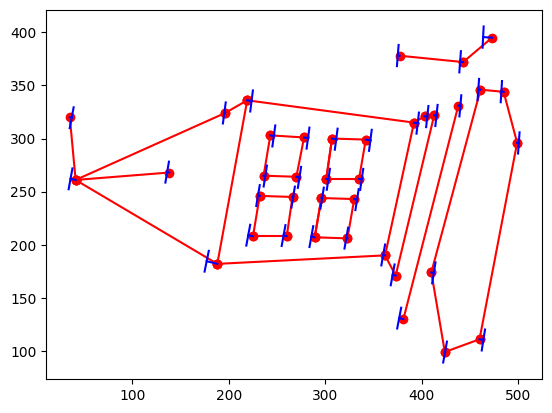

In [14]:
def draw_epipolar_lines(pts1, pts2, F, edges):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    F: np.array
        array of size (3, 3). Fundamental matrix.

    Returns:
    --------
    lines: list
        list of tuples. Each tuple contains the coordinates of the two extremal points of the epipolar segment drawn.
    """
    
    plot_edges(pts1, edges)

    for i in range(len(pts1)):
        
        # Get homogeneous coordinates
        p = np.array([*pts1[i], 1])
        p_ = np.array([*pts2[i], 1])

        l = F @ p_
        p_proj = find_intersectv2(l, p)

        x = [p[0], p_proj[0]]
        y = [p[1], p_proj[1]]
        plt.plot(x, y, 'b-')
        
        p1, p2 = get_segment(l, p_proj, alpha=10)

        x = [p1[0], p2[0]]
        y = [p1[1], p2[1]]
        plt.plot(x, y, 'b-')

        #check if p2 - p1 is orthogonal to p - p_proj

        #v1 = p2 - p1
        #v2 = p - p_proj
        #print(v1 @ v2)

draw_epipolar_lines(data[0], data[1], F, data[2])


**4.b)** Do the same switching the roles of pts1 and pts2.

3.063313885910512


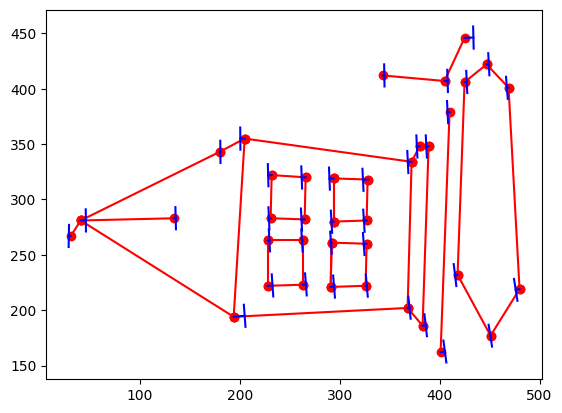

In [15]:
F = compute_F(data[1], data[0])
mean_dist = compute_mean_distance(data[1], data[0], F)
print(mean_dist)
draw_epipolar_lines(data[1], data[0], F, data[2])

**5)** Do the same thing using the Harltley normalization:

**5.a)** Compute the matrices $T_1$ and $T_2$.

In [16]:
def get_T(pts, sigma=2):
    """
    Params:
    -------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).

    Returns:
    --------
    T: np.array
        array of size (3, 3).
        T is the transformation matrix that normalizes the points.
    """
    mean = np.mean(pts, axis=0)
    std = np.std(pts, axis=0)
    T = np.array([[sigma/std[0], 0, -sigma * mean[0]/std[0]],
                  [0, sigma/std[1], -sigma * mean[1]/std[1]],
                  [0, 0, 1]])
    
    return T

In [17]:
T1 = get_T(data[0])
T2 = get_T(data[1])

pts_hom = np.array([*data[0].T, np.ones(len(data[0]))]).T
pts_norm = pts_hom @ T1.T

mean = np.mean(pts_norm, axis=0)
std = np.std(pts_norm, axis=0)
print(mean, std)

[-3.03850512e-16 -1.12190958e-15  1.00000000e+00] [2. 2. 0.]


HARTLEY : F' des points normalisés est pas bonne.

Refaire une SVD de F', on obtient U' Sigma' V', on prend Sigma'' où on remplace la dernière valeur singulière par 0 et F'' = U' Sigma'' V' puis on refait F_final = T1^T F'' T2

**5.b)** Compute the new matrice $F'$

#### Attention ####
_____

Quand je commente la ligne "S[-1] = 0", donc je ne fais pas ce que tu as dit en cours, la mean distance s'améliore ... elle passe de 0.76 à 0.72 dans un sens et de 0.73 à 0.70 dans l'autre sens.

In [18]:
def compute_F_norm(pts1, pts2):
    pts1_hom = np.array([*pts1.T, np.ones(len(pts1))]).T
    pts1_norm = pts1_hom @ T1.T

    pts2_hom = np.array([*pts2.T, np.ones(len(pts2))]).T
    pts2_norm = pts2_hom @ T2.T

    F = compute_F(pts1_norm[:, :2], pts2_norm[:, :2])

    SVD = np.linalg.svd(F)
    U, S, Vh = SVD # Vh is the transpose of V

    # set smallest singular value to 0
    S[-1] = 0
    SVD = U @ np.diag(S) @ Vh

    # Unnormalize F
    F = T1.T @ SVD @ T2

    return F

In [19]:
F = compute_F_norm(data[0], data[1])

**5.c)** Report the mean distance between the points and the corresponding epipolar lines.

In [20]:
mean_dist = compute_mean_distance(data[0], data[1], F)
print(mean_dist)

0.7645570708777072


**5.d)** Draw the epipolar lines associated with the points from `pts2` and overlay them on the points from
`pts1`, drawn using `plot_edges`.

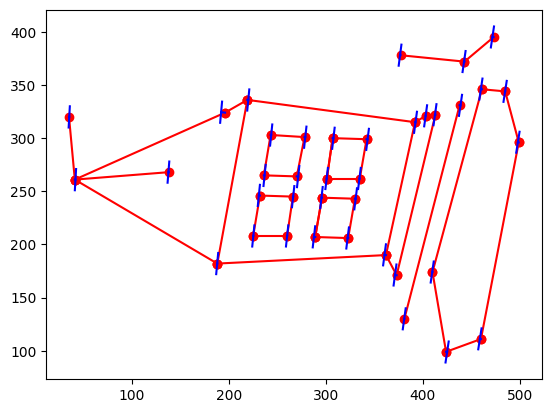

In [21]:
draw_epipolar_lines(data[0], data[1], F, data[2])

**5.e)** Do the same switching the roles of `pts1` and `pts2`.

0.7367932930216546


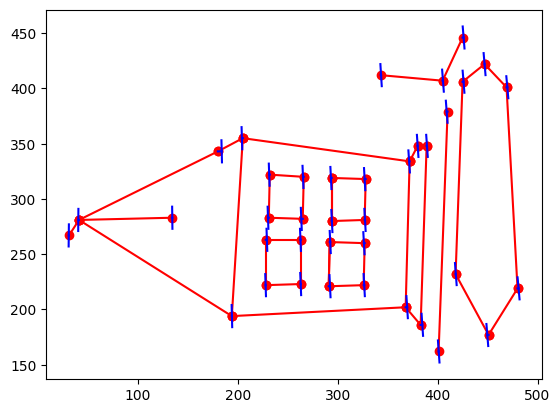

In [22]:
F = compute_F_norm(data[1], data[0])

mean_dist = compute_mean_distance(data[1], data[0], F)
print(mean_dist)

draw_epipolar_lines(data[1], data[0], F, data[2])

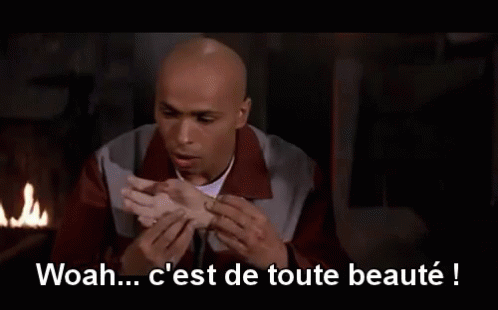